In [1]:
# Along-Fjord Properties Gif
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import gsw

In [2]:
Qsg = 700
hs = 9
File1 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/state_' + str(format(hs,'03d')) + '.nc')
File2 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/grid_' + str(format(hs,'03d')) + '.nc')
File3 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/Adv_' + str(format(hs,'03d')) + '.nc')
File4 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_rot/Dif_' + str(format(hs,'03d')) + '.nc')

T0 = 1
Tn = len(File1.T)
State = File1.isel(X=range(120), Xp1=range(121), Y=range(30,39), Yp1=range(30,40), T=range(T0,Tn))
Grid = File2.isel(X=range(120), Xp1=range(121), Y=range(30,39), Yp1=range(30,40))
Adv = File3.isel(X=range(120), Xp1=range(121), Y=range(30,39), Yp1=range(30,40))
Dif = File4.isel(X=range(120), Xp1=range(121), Y=range(30,39), Yp1=range(30,40))


x = Grid.X.data
z = Grid.Z.data
CV = Grid.rA.data.mean(0) * Grid.HFacC.data.mean(1) * Grid.drF.data[:,None]  # Cell Volume
#CV1 = CV0  * Grid.drF.data
U0 = State.U.data.mean(2)
u = (U0[:,:,1:]+U0[:,:,:-1])/2

W0 = State.W.data.mean(2)
bt = np.zeros((W0.shape[0],1,W0.shape[2])) # Add vertical velocity (0 m/s) at the bottom
W = np.concatenate((W0, bt), axis=1)
w = (W[:,1:,:] + W[:,:-1,:]) / 2


s = State.S.data.mean(2) # Salinity
pt = State.Temp.data.mean(2) # Potential temperature
pres = gsw.p_from_z(z, 55)
p = np.tile(pres,[len(x),1]).T


Cp = 3994  # Specific heat content J/kg/C
rho = 999.8 # Density
Difx0 = Dif.DFxE_TH.data.mean(2) # Zonal Diffusive Flux of Pot.Temperature (degC.m^3/s)
difx = (Difx0[:,:,1:]+Difx0[:,:,:-1])/2
Difr0 = Dif.DFrI_TH.data.mean(2) # Vertical Diffusive Flux of Pot.Temperature (Implicit part)
Difr = np.concatenate((Difr0, bt), axis=1)
difz = (Difr[:,1:,:] + Difr[:,:-1,:]) / 2

Advx0 = Adv.ADVx_TH.data.mean(2) # Zonal Advective Flux of Pot.Temperature (degC.m^3/s)
advx = (Advx0[:,:,1:]+Advx0[:,:,:-1])/2
Advr0 = Adv.ADVr_TH.data.mean(2) # Vertical Advective Flux of Pot.Temperature (Implicit part)
Advr = np.concatenate((Advr0, bt), axis=1)
advz = (Advr[:,1:,:] + Advr[:,:-1,:]) / 2


#np.shape(u), np.shape(w), np.shape(difx), np.shape(difz)
np.shape(CV)

(50, 120)

In [3]:
mask = (s == 0) # Exclude data covered by the sill
s[mask] = np.nan
pt[mask] = np.nan
u[mask] = np.nan
w[mask] = np.nan
difx[mask] = np.nan
difz[mask] = np.nan

range1 = np.array([np.nanmax(difx), np.nanmin(difx), np.nanmean(difx)])
range2 = np.array([np.nanmax(difz), np.nanmin(difz), np.nanmean(difz)])

range3 = np.array([np.nanmax(advx), np.nanmin(advx), np.nanmean(advx)])
range4 = np.array([np.nanmax(advz), np.nanmin(advz), np.nanmean(advz)])

#range3, range4
np.nanmin(pt) - 9

-3.279432773590088

In [5]:
Xl, Xr = 53, 85 # X range
Zu, Zl = 0, 31 # Z range

cv = CV[Zu:Zl,Xl:Xr]

cm = np.linspace(-5,5,20) # Contour range
#cm = np.linspace(-2,0,20) # Contour range
cs = np.linspace(1015,1021,20)
cmap = 'RdBu_r'
#cmap = 'YlGnBu_r'

skip=(slice(None,None,3))


fig_path = "/Users/weiyangbao/Documents/Results_Figs/HeatBudget/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

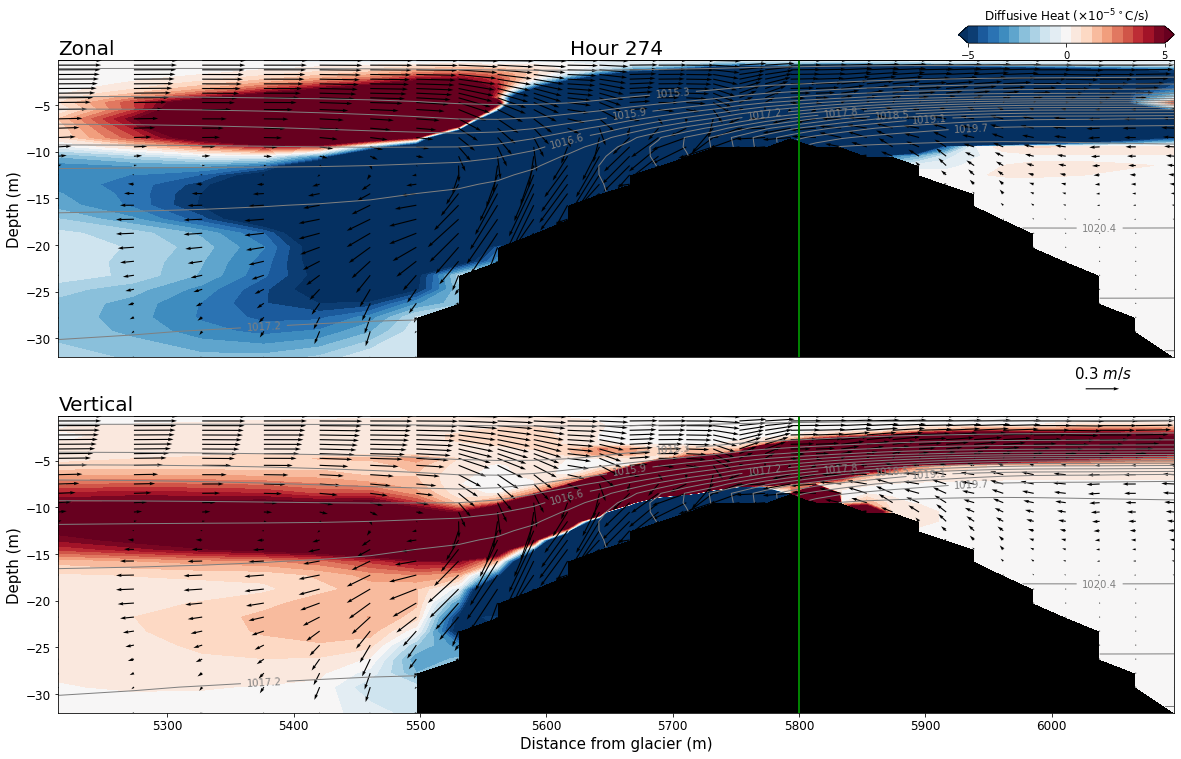

In [6]:

for t in range(274,275):
    fig1 = plt.figure(figsize=(20,12))
    fig1.tight_layout()  
   
    rho = gsw.rho(s[t,:,:], pt[t,:,:], p) # Density
    
    ax1 = fig1.add_subplot(211)
    im1 = ax1.contourf(x[Xl:Xr], z[Zu:Zl], difx[t,Zu:Zl,Xl:Xr]/cv*1e5, cm, cmap=cmap, extend='both')
    #ax1.plot(x[Xl:Xr],-h1[Xl:Xr], '--b',lw=2)
    #ax1.plot(x[Xl:Xr],-h2[Xl:Xr], '--r',lw=2)
    ax1.xaxis.set_visible(False)
    ax1.set_xlim([x[Xl], x[Xr-1]])
    ax1.set_facecolor('k')
    # Set Colorbar
    cbaxes = fig1.add_axes([0.75, .9, 0.15, 0.02])
    cbar = fig1.colorbar(im1,cax=cbaxes, orientation='horizontal')
    cbar.set_ticks([-5, 0, 5])
    cbar.ax.set_title(r'Diffusive Heat $(\times{10^{-5}}^\circ$C/s)', size=12)
    
    # Plot isohalines
    CS1 = ax1.contour(x[Xl:Xr], z[Zu:Zl], rho[Zu:Zl,Xl:Xr], cs, colors='grey', linewidths=1)
    plt.clabel(CS1, cs[1::2], fmt='%1.1f', fontsize=10, inline=True)
    ax1.axvline(x=5800, color='g',lw=2)
    ax1.set_ylabel('Depth (m)', size=15)
    ax1.tick_params(labelsize=12)
    ax1.set_title(r'Zonal', loc='left', size=20)
    ax1.set_title(r'Hour '+str(t), loc='center', size=20)
    ax1.tick_params(labelsize=12)
    
    # Plot Velocity
    Q_1 = ax1.quiver(x[Xl:Xr],z[Zu:Zl],u[t,Zu:Zl,Xl:Xr], w[t,Zu:Zl,Xl:Xr]*20,scale=10, width=0.001, color='k')
    ax1.quiverkey(Q_1, 0.85, 0.5, 0.3,r'0.3 $m/s$', fontproperties={'size' : 15}, coordinates='figure')
    
    
    ax2 = fig1.add_subplot(212)
    im2 = ax2.contourf(x[Xl:Xr], z[Zu:Zl], difz[t, Zu:Zl,Xl:Xr]/cv*1e5, cm, cmap=cmap, extend='both')
    ax2.set_xlim([x[Xl], x[Xr-1]])
    ax2.set_facecolor('k')

    # Plot isohalines
    CS2 = ax2.contour(x[Xl:Xr], z[Zu:Zl], rho[Zu:Zl,Xl:Xr], cs, colors='grey', linewidths=1)
    plt.clabel(CS2, cs[1::2], fmt='%1.1f', fontsize=10, inline=True)
    ax2.axvline(x=5800, color='g',lw=2)
    ax2.set_ylabel('Depth (m)', size=15)
    ax2.tick_params(labelsize=12)
    ax2.set_title(r'Vertical', loc='left', size=20)
    ax2.set_xlabel('Distance from glacier (m)', size=15)
    ax2.tick_params(labelsize=12)
    
    # Plot Velocity
    Q_2 = ax2.quiver(x[Xl:Xr],z[Zu:Zl],u[t,Zu:Zl,Xl:Xr], w[t,Zu:Zl,Xl:Xr]*20,scale=10, width=0.001, color='k')
    
    #plt.close()
    #fig1.savefig(fig_path + '/time_r' + format(t, '03d') + '.png', dpi=200, bbox_inches='tight')

In [ ]:
for t in range(24,49):
    fig2 = plt.figure(figsize=(20,12))
    fig2.tight_layout()  
   
    rho = gsw.rho(s[t,:,:], pt[t,:,:], p) # Density
    
    ax1 = fig2.add_subplot(211)
    im1 = ax1.contourf(x[Xl:Xr], z[Zu:Zl], advx[t,Zu:Zl,Xl:Xr]/cv*1e2, cm, cmap=cmap, extend='both')
    #ax1.plot(x[Xl:Xr],-h1[Xl:Xr], '--b',lw=2)
    #ax1.plot(x[Xl:Xr],-h2[Xl:Xr], '--r',lw=2)
    ax1.xaxis.set_visible(False)
    ax1.set_xlim([x[Xl], x[Xr-1]])
    ax1.set_facecolor('k')
    # Set Colorbar
    cbaxes = fig2.add_axes([0.75, .9, 0.15, 0.02])
    cbar = fig2.colorbar(im1,cax=cbaxes, orientation='horizontal')
    cbar.set_ticks([-5, 0, 5])
    cbar.ax.set_title(r'Advective Heat $(\times{10^{-2}}^\circ$C/s)', size=12)
    
    # Plot isohalines
    CS1 = ax1.contour(x[Xl:Xr], z[Zu:Zl], rho[Zu:Zl,Xl:Xr], cs, colors='grey', linewidths=1)
    plt.clabel(CS1, cs[1::2], fmt='%1.1f', fontsize=10, inline=True)
    ax1.axvline(x=5800, color='g',lw=2)
    ax1.set_ylabel('Depth (m)', size=15)
    ax1.tick_params(labelsize=12)
    ax1.set_title(r'Zonal', loc='left', size=20)
    ax1.set_title(r'Hour '+str(t), loc='center', size=20)
    ax1.tick_params(labelsize=12)
    
    # Plot Velocity
    Q_1 = ax1.quiver(x[Xl:Xr],z[Zu:Zl],u[t,Zu:Zl,Xl:Xr], w[t,Zu:Zl,Xl:Xr]*20,scale=10, width=0.001, color='k')
    ax1.quiverkey(Q_1, 0.85, 0.5, 0.3,r'0.3 $m/s$', fontproperties={'size' : 15}, coordinates='figure')
    
    
    ax2 = fig2.add_subplot(212)
    im2 = ax2.contourf(x[Xl:Xr], z[Zu:Zl], advz[t, Zu:Zl,Xl:Xr]/cv*1e2, cm, cmap=cmap, extend='both')
    ax2.set_xlim([x[Xl], x[Xr-1]])
    ax2.set_facecolor('k')

    # Plot isohalines
    CS2 = ax2.contour(x[Xl:Xr], z[Zu:Zl], rho[Zu:Zl,Xl:Xr], cs, colors='grey', linewidths=1)
    plt.clabel(CS2, cs[1::2], fmt='%1.1f', fontsize=10, inline=True)
    ax2.axvline(x=5800, color='g',lw=2)
    ax2.set_ylabel('Depth (m)', size=15)
    ax2.tick_params(labelsize=12)
    ax2.set_title(r'Vertical', loc='left', size=20)
    ax2.set_xlabel('Distance from glacier (m)', size=15)
    ax2.tick_params(labelsize=12)
    
    # Plot Velocity
    Q_2 = ax2.quiver(x[Xl:Xr],z[Zu:Zl],u[t,Zu:Zl,Xl:Xr], w[t,Zu:Zl,Xl:Xr]*20,scale=10, width=0.001, color='k')
    
    plt.close()
    fig2.savefig(fig_path + '/time_r' + format(t, '03d') + '.png', dpi=200, bbox_inches='tight')

In [ ]:
for t in range(24,49):
    fig3, ax1 = plt.subplots(figsize=(20,6))
    fig3.tight_layout()  
   
    rho = gsw.rho(s[t,:,:], pt[t,:,:], p) # Density
    im1 = ax1.contourf(x[Xl:Xr], z[Zu:Zl], pt[t,Zu:Zl,Xl:Xr]-9, cm, cmap=cmap, extend='both')
    #ax1.plot(x[Xl:Xr],-h1[Xl:Xr], '--b',lw=2)
    #ax1.plot(x[Xl:Xr],-h2[Xl:Xr], '--r',lw=2)
    ax1.xaxis.set_visible(False)
    ax1.set_xlim([x[Xl], x[Xr-1]])
    ax1.set_facecolor('k')
    # Set Colorbar
    cbaxes = fig3.add_axes([0.75, 1.02, 0.15, 0.02])
    cbar = fig3.colorbar(im1,cax=cbaxes, orientation='horizontal')
    cbar.set_ticks([-2, -1, 0])
    cbar.ax.set_title(r'Potential Temp Anomaly $(^\circ$C)', size=12)
    
    # Plot isohalines
    CS1 = ax1.contour(x[Xl:Xr], z[Zu:Zl], rho[Zu:Zl,Xl:Xr], cs, colors='grey', linewidths=1)
    plt.clabel(CS1, cs[1::2], fmt='%1.1f', fontsize=10, inline=True)
    ax1.axvline(x=5800, color='g',lw=2)
    ax1.set_ylabel('Depth (m)', size=15)
    ax1.tick_params(labelsize=12)
    ax1.set_title(r'Hour '+str(t), loc='center', size=20)
    ax1.tick_params(labelsize=12)
    
    # Plot Velocity
    Q_1 = ax1.quiver(x[Xl:Xr],z[Zu:Zl],u[t,Zu:Zl,Xl:Xr], w[t,Zu:Zl,Xl:Xr]*20,scale=10, width=0.001, color='k')
    ax1.quiverkey(Q_1, 0.9, 0.5, 0.3,r'0.3 $m/s$', fontproperties={'size' : 15}, coordinates='figure')
    
    plt.close()
    fig3.savefig(fig_path + '/time_r' + format(t, '03d') + '.png', dpi=200, bbox_inches='tight')

In [ ]:
# Generate GIF from saved output figures
import imageio
import glob

images = []
imagenames = sorted(glob.glob(fig_path + '/time_r*.png'))

for filename in imagenames:
    images.append(imageio.imread(filename))
imageio.mimsave(fig_path + 'Pta018_24-48.gif', images, duration=.6)